In [1]:
import matplotlib.pyplot as plt
import os
import torch
from typing import List
import pandas as pd

import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing as preprocessing
import nnts.torch.models
import nnts.torch.models.trainers as trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import covs 
import nnts.pandas
import nnts


%load_ext autoreload
%autoreload 2

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
data_path = "data"
model_name = "seg-lstm"
dataset_name = "traffic_hourly"
results_path = "nb-results"
metadata_path = os.path.join(data_path, f"{model_name}-monash.json")
metadata = nnts.data.metadata.load(dataset_name, path=metadata_path)
datafile_path = os.path.join(data_path, metadata.filename)
PATH = os.path.join(results_path, model_name, metadata.dataset)

df_orig, *_ = nnts.pandas.read_tsf(datafile_path)
params = nnts.models.Hyperparams()
splitter = nnts.pandas.LastHorizonSplitter()

nnts.loggers.makedirs_if_not_exists(PATH)

In [3]:
scenario_list: List[nnts.experiments.CovariateScenario] = []

# Add the baseline scenarios
for seed in [42, 43, 44, 45, 46]:
    scenario_list.append(
        nnts.experiments.CovariateScenario(metadata.prediction_length, error=0.0, covariates=0, seed=seed)
    )

# Models for full forecast horizon with covariates
for covariates in [1, 2, 3]:
    for error in covs.errors[metadata.dataset]:
        scenario_list.append( 
            nnts.experiments.CovariateScenario(
                metadata.prediction_length, error, covariates=covariates
            )
        )

scenario_list.append(
    nnts.experiments.CovariateScenario(
        metadata.prediction_length, 0, covariates=3, skip=1
    )
)

KeyError: 'traffic_hourly'

In [4]:
import nnts.torch.data.datasets
import torch.utils.data
import nnts.data

In [5]:
trn_length = 17544 - 1736 - metadata.context_length - metadata.prediction_length
val_test_length = 1736
test_length = metadata.context_length + metadata.prediction_length

In [6]:
for scenario in scenario_list[:5]:
    # params.batches_per_epoch = 500
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df, scenario = covs.prepare(df_orig.copy(), scenario)
    #split_data = splitter.split(df, metadata)
    split_data = nnts.data.splitter.split_dataframe(
        df, trn_length, val_test_length, test_length
    )
    trn_dl, val_dl, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    logger = nnts.loggers.ProjectRun(
        nnts.loggers.JsonFileHandler(
            path=PATH, filename=f"{scenario.name}.json"
        ),
        project=f"{model_name}-{metadata.dataset}",
        run=scenario.name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
    )
    net = covs.model_factory(model_name, params, scenario, metadata)

    trner = trainers.TorchEpochTrainer(
        nnts.models.TrainerState(), 
        net, 
        params, 
        metadata, 
        f"{PATH}/{scenario.name}.pt",
        logger=logger
    )
    evaluator = trner.train(trn_dl, val_dl)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed-42.pt
{'train_loss': 2.9027360142208636e-06, 'valid_loss': 2.8677952286670916e-05, 'elapsed_time': 219.2738612089306}
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed-42.pt
{'train_loss': 1.6748747384554008e-06, 'valid_loss': 1.6797586795291863e-05, 'elapsed_time': 219.98098204191774}
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed-42.pt
{'train_loss': 1.35092489017552e-06, 'valid_loss': 1.5698746210546233e-05, 'elapsed_time': 231.7562137497589}
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed-42.pt
{

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


{'mse': 0.00132922, 'mae': 0.018260229378938675, 'mape': inf, 'smape': 0.4220305383205414, 'abs_error': 2644.3738, 'mase': 0.71494675, 'rmse': 0.028779257088899612}
Run cov-0-pearsn-0-pl-168-seed-42 finished
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed-43.pt
{'train_loss': 2.8679471597570227e-06, 'valid_loss': 2.756318099272903e-05, 'elapsed_time': 232.02857141708955}
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed-43.pt
{'train_loss': 1.5844233303141664e-06, 'valid_loss': 1.6782001694082282e-05, 'elapsed_time': 232.9384317919612}
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-s

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


{'mse': 0.0013766022, 'mae': 0.019040044397115707, 'mape': inf, 'smape': 0.4288288354873657, 'abs_error': 2757.303, 'mase': 0.7454789, 'rmse': 0.029888350516557693}
Run cov-0-pearsn-0-pl-168-seed-43 finished
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed-44.pt
{'train_loss': 3.468697741482174e-06, 'valid_loss': 3.2680705771781504e-05, 'elapsed_time': 230.4537082919851}
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed-44.pt
{'train_loss': 2.2491019535664236e-06, 'valid_loss': 1.8934166291728616e-05, 'elapsed_time': 233.16752087464556}
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-s

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


{'mse': 0.0014870641, 'mae': 0.019438568502664566, 'mape': inf, 'smape': 0.43333518505096436, 'abs_error': 2815.0156, 'mase': 0.7610824, 'rmse': 0.03059207834303379}
Run cov-0-pearsn-0-pl-168-seed-44 finished
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed-45.pt
{'train_loss': 2.751736474237987e-06, 'valid_loss': 2.404058068350423e-05, 'elapsed_time': 226.91408825013787}
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed-45.pt
{'train_loss': 1.5534191106780781e-06, 'valid_loss': 1.741411142575089e-05, 'elapsed_time': 228.86640029214323}
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-s

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


{'mse': 0.001388275, 'mae': 0.018463432788848877, 'mape': inf, 'smape': 0.44764718413352966, 'abs_error': 2673.8005, 'mase': 0.7229027, 'rmse': 0.02945154346525669}
Run cov-0-pearsn-0-pl-168-seed-45 finished
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed-46.pt
{'train_loss': 4.294827249395894e-06, 'valid_loss': 3.193246811861172e-05, 'elapsed_time': 254.87646145792678}
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed-46.pt
{'train_loss': 2.243619292130461e-06, 'valid_loss': 1.86030229087919e-05, 'elapsed_time': 241.27866958314553}
Artifact saved to nb-results/seg-lstm/traffic_hourly/cov-0-pearsn-0-pl-168-seed

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


In [7]:
csv_aggregator = covs.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

In [8]:
results = pd.read_csv(f"{PATH}/results.csv")
results

,input_dim,hidden_dim,n_layers,dropout,output_dim,batch_size,lr,epochs,patience,rnn_type,...,valid_loss,elapsed_time,mse,mae,mape,smape,abs_error,mase,rmse,run_time
0,1,40,2,0.1,1,128,0.001,100,10,lstm,...,0.000012,227.647154,0.001329,0.018260,inf,0.422031,2644.373779,0.714947,0.028779,22688.274960
1,1,40,2,0.1,1,128,0.001,100,10,lstm,...,0.000012,232.676804,0.001377,0.019040,inf,0.428829,2757.302979,0.745479,0.029888,22995.765537
2,1,40,2,0.1,1,128,0.001,100,10,lstm,...,0.000012,220.289456,0.001487,0.019439,inf,0.433335,2815.015625,0.761082,0.030592,22727.021180
3,1,40,2,0.1,1,128,0.001,100,10,lstm,...,0.000010,235.663388,0.001388,0.018463,inf,0.447647,2673.800537,0.722903,0.029452,23126.592882
4,1,40,2,0.1,1,128,0.001,100,10,lstm,...,0.000011,239.601763,0.001629,0.020412,inf,0.439789,2956.000244,0.799200,0.032175,23700.420810


/Users/garethdavies/Development/workspaces/nnts/projects/rnn-covariates/covs.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/rnn-covariates/covs.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/rnn-covariates/covs.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

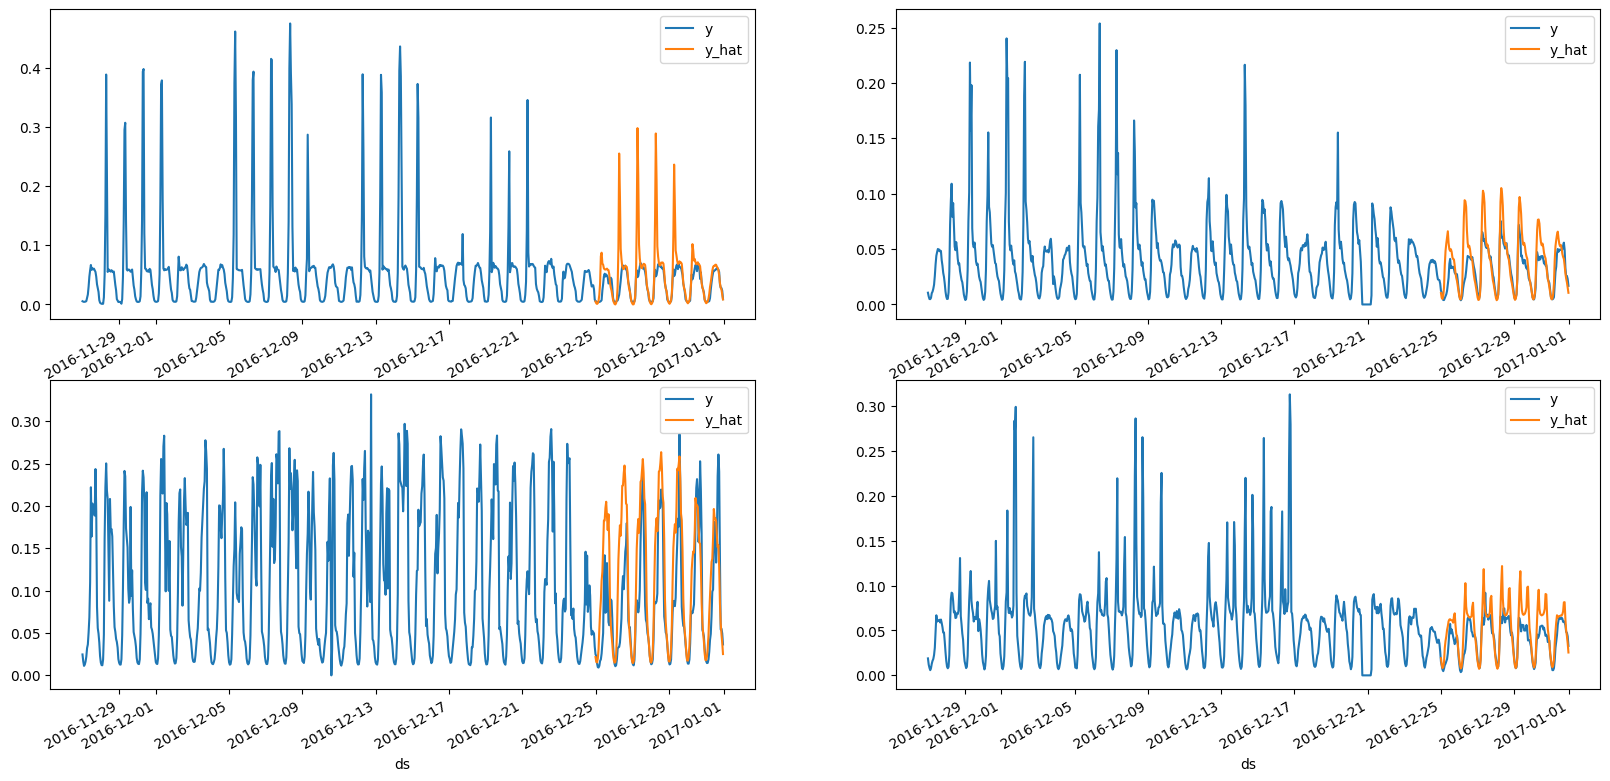

In [9]:
df_list = covs.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = covs.plot(df_list, scenario.prediction_length)

In [10]:
univariate_results = results.loc[
    (results["covariates"] == 0)
    & (results["prediction_length"] == metadata.prediction_length),
    ["smape", "mape", "rmse", "mae"],
]

univariate_results.mean(), univariate_results.std(), univariate_results.count()

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


(smape    0.434326
 mape          inf
 rmse     0.030177
 mae      0.019123
 dtype: float64,
 smape    0.009870
 mape          NaN
 rmse     0.001297
 mae      0.000858
 dtype: float64,
 smape    5
 mape     5
 rmse     5
 mae      5
 dtype: int64)

In [11]:
cols = ["dataset", "error", "pearson", "covariates", "prediction_length", "smape"]

In [12]:
results.loc[
    (results["covariates"] > 0)
    & (results["error"].isin([0.000000, 0.4714285714285714, 1.65])),
    cols,
].sort_values(by=['covariates', 'error'])

,dataset,error,pearson,covariates,prediction_length,smape


In [13]:
sorted(results["error"].unique().tolist())

[0.0]

In [14]:
import numpy as np
np.linspace(0, 0.6, 8).tolist()

[0.0,
 0.08571428571428572,
 0.17142857142857143,
 0.2571428571428571,
 0.34285714285714286,
 0.4285714285714286,
 0.5142857142857142,
 0.6]